In [2]:
import h5py
import json
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from dyn_net.utils.criticality import find_theta_c_from_degree_distribution

# USEFUL FUNCTION FOR DATA ANALYSIS #
def find_repo_root() -> Path:
    return next(p for p in Path.cwd().parents if (p / "pyproject.toml").exists())


def read_stats_df(stats_path: Path) -> pd.DataFrame:
    with h5py.File(stats_path, "r", swmr=True) as fh:
        dset = fh["stats"]
        dset.refresh()
        fieldnames = [s.decode("utf-8") for s in dset.attrs["fieldnames"]]
        return pd.DataFrame(dset[...], columns=fieldnames)


def read_aggregate_dfs(agg_path: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    with h5py.File(agg_path, "r", swmr=True) as fh:
        mean_dset = fh["mean"]
        std_dset = fh["std"]
        mean_dset.refresh()
        std_dset.refresh()
        field_attr = fh.attrs.get("fieldnames")
        if field_attr is None:
            raise ValueError(f"Missing fieldnames in {agg_path}")
        fieldnames = [s.decode("utf-8") for s in np.asarray(field_attr).tolist()]
        mean_df = pd.DataFrame(mean_dset[...], columns=fieldnames)
        std_df = pd.DataFrame(std_dset[...], columns=fieldnames)
        return mean_df, std_df


def read_state_df(state_path: Path) -> pd.DataFrame:
    with h5py.File(state_path, "r", swmr=True) as fh:
        dset_state = fh["state"]
        dset_time = fh["time"]
        dset_step = fh["step"]
        dset_state.refresh()
        dset_time.refresh()
        dset_step.refresh()
        state = dset_state[...]
        df = pd.DataFrame(state, columns=[f"x_{i}" for i in range(state.shape[1])])
        df.insert(0, "t", dset_time[...])
        df.insert(0, "step", dset_step[...])
        return df


def read_timings(timings_path: Path) -> dict:
    return json.loads(Path(timings_path).read_text())


def read_config(config_path: Path) -> dict:
    return json.loads(Path(config_path).read_text())





# Summarize mean_x1: across-realization variance and time variability over the tail window.
def summarize_mean_x1_aggregate(agg_path: Path, frac: float = 0.8, use_abs: bool = False) -> dict:
    mean_df, std_df = read_aggregate_dfs(agg_path)
    with h5py.File(agg_path, "r", swmr=True) as fh:
        count = int(fh["count"][()])
    col = "mean_x1_abs" if use_abs else "mean_x1"
    if col not in mean_df.columns:
        raise ValueError(f"{col} column missing from aggregate.")
    if "t" not in mean_df.columns:
        raise ValueError("t column missing from aggregate.")
    t_max = float(mean_df["t"].max())
    t_start = frac * t_max
    tail = mean_df[mean_df["t"] >= t_start]
    if tail.empty:
        raise ValueError("No samples in tail window; check frac/t_max.")
    series = tail[col]
    time_var = float(series.var(ddof=0))
    time_std = float(np.sqrt(time_var))
    tail_std = std_df.loc[tail.index, col]
    return {
        "mean_x1": float(series.mean()),
        "time_var_x1": time_var,
        "time_std_x1": time_std,
        "var_x1": float((tail_std ** 2).mean()),
        "t_start": float(tail["t"].iloc[0]),
        "t_end": float(tail["t"].iloc[-1]),
        "count": count,
    }


def load_sweep_table(table_path: Path) -> pd.DataFrame:
    return pd.read_csv(table_path, sep='	')


# Build a per-run table by reading each run folder's aggregate.h5.
def build_phase_diagram(
    sweep_dir: Path,
    sweep_table: pd.DataFrame,
    *,
    frac: float = 0.8,
    theta_c: float | None = None,
) -> pd.DataFrame:
    sweep_dir = Path(sweep_dir)
    run_to_theta = dict(zip(sweep_table["run_id"], sweep_table["system.params.theta"]))
    rows = []
    for run_id, theta in run_to_theta.items():
        run_dir = sweep_dir / str(run_id)
        agg_path = run_dir / "aggregate.h5"
        if not agg_path.exists():
            print(str(agg_path) + " not found")
            continue
        theta = float(theta)
        use_abs = theta_c is not None and theta > theta_c
        summary = summarize_mean_x1_aggregate(agg_path, frac=frac, use_abs=use_abs)
        rows.append({
            "run": run_id,
            "theta": theta,
            "use_abs": use_abs,
            **summary,
        })
    return pd.DataFrame(rows)


# Compute theta_c from the base config used for the sweep.
def compute_theta_c_from_config(config_path: Path, *, theta_bracket=(1e-6, 1.0)) -> float:
    config_used = read_config(config_path)
    degree_distribution = config_used["network"]["params"]["degree_distribution"]
    sigma = float(config_used["noise"]["params"]["sigma"])
    return find_theta_c_from_degree_distribution(
        degree_distribution=degree_distribution,
        sigma=sigma,
        theta_bracket=theta_bracket,
    )

## Analysis of direct numerical simulations


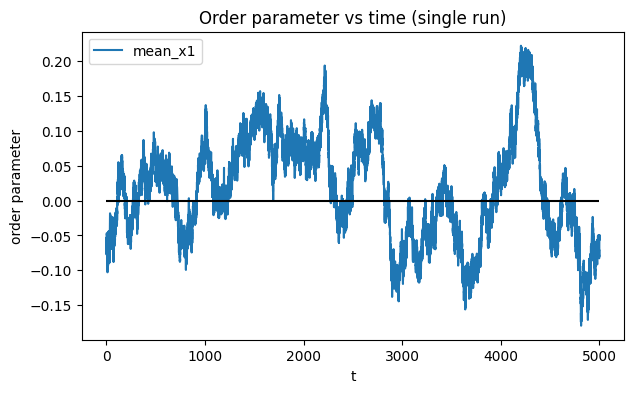

In [7]:
# Read outputs produced by prototyping_simulations.ipynb (stats.h5/state.h5)
repo_root = find_repo_root()
sim_output_dir = repo_root / 'notebooks' / 'prototyping'
stats_path = sim_output_dir / 'stats.h5'
state_path = sim_output_dir / 'state.h5'

stats_df = read_stats_df(sim_output_dir / "stats.h5")
state_df = read_state_df(sim_output_dir / "state.h5")

fig, ax = plt.subplots(figsize=(7, 4))
stats_df.plot(x='t', y='mean_x1', ax=ax, label='mean_x1')
# if 'mean_x1_abs' in stats_df.columns:
#     stats_df.plot(x='t', y='mean_x1_abs', ax=ax, label='mean_x1_abs', alpha=0.7)
ax.set_xlabel('t')
ax.set_ylabel('order parameter')
ax.set_title('Order parameter vs time (single run)')
ax.hlines(0,0,state_df["t"].iloc[-1],"k")
ax.legend()


## Phase diagram

Aggregate the sweep results and plot order parameter vs. theta.


In [ ]:
# Aggregate across runs for each theta and plot the mean_x1 order parameter.
repo_root = find_repo_root()
sweep_dir = repo_root / "results" / "phase_diagram_double_well_configuration_model_PowerLaw_Alpha35/"
sweep_table_path = repo_root / "params" / "sweep_theta_double_well_configuration_model_PowerLaw_Alpha35.tsv"
sweep_table = load_sweep_table(sweep_table_path)
config_path = repo_root / "configs" / "config_double_well_configuration_model_PowerLaw_Alpha35.json"

theta_c = compute_theta_c_from_config(config_path)

phase_df = build_phase_diagram(
    sweep_dir,
    sweep_table,
    frac=0.7,
    theta_c=theta_c
)
phase_df["std"] = np.sqrt(phase_df["var_x1"])
phase_df["theta_scaled"] = phase_df["theta"] / theta_c

fig, ax = plt.subplots()
ax = phase_df.plot(x="theta_scaled", y="mean_x1", marker="o", label="",legend=False, ax=ax)
ax.fill_between(
    phase_df["theta_scaled"],
    phase_df["mean_x1"] - phase_df["std"],
    phase_df["mean_x1"] + phase_df["std"],
    alpha=0.2,
    label="Ensemble variability"
)

ax.fill_between(
    phase_df["theta_scaled"],
    phase_df["mean_x1"] - phase_df["time_std_x1"],
    phase_df["mean_x1"] + phase_df["time_std_x1"],
    alpha=0.6,
    label="Order parameter time variability"
)
ax.set_ylabel(r"$\langle x_1 \rangle_0$", size=16)
ax.set_xlabel(r"$\theta / \theta_c$", size=16)
ax.set_title(r"Power Law $\alpha = 3.5$")
ax.legend()
plt.show()
#fig.savefig(repo_root / "figures" / "Phase_Diagram_DoubleWell_NoRotation_PowerLaw_Alpha25.png", dpi=600)

### Order Parameter as a function of time

In [ ]:
# Plot order parameter x_1 vs time for selected theta values
repo_root = find_repo_root()
sweep_dir = repo_root / 'results' / 'phase_diagram_double_well_configuration_model_PowerLaw_Alpha35/'
sweep_table_path = repo_root / 'params' / 'sweep_theta_double_well_configuration_model_PowerLaw_Alpha35.tsv'
config_path = repo_root / 'configs' / 'config_double_well_configuration_model_PowerLaw_Alpha35.json'

theta_c = compute_theta_c_from_config(config_path)
sweep_table = load_sweep_table(sweep_table_path)
theta_values = sweep_table['system.params.theta'].astype(float).values
run_ids = sweep_table['run_id'].astype(str).values

targets = np.array([0.5,0.7,1,1.1,1.3,1.5,2]) * theta_c
selected = []
for target in targets:
    idx = int(np.argmin(np.abs(theta_values - target)))
    selected.append((run_ids[idx], float(theta_values[idx])))

fig, axes = plt.subplots(len(selected), 1, figsize=(7, 2.4 * len(selected)), sharex=True)
if len(selected) == 1:
    axes = [axes]

for ax, (run_id, theta) in zip(axes, selected):
    agg_path = sweep_dir / str(run_id) / 'aggregate.h5'
    if not agg_path.exists():
        continue
    mean_df, _ = read_aggregate_dfs(agg_path)
    use_abs = theta > theta_c
    if use_abs:
        if 'mean_x1_abs' in mean_df.columns:
            y = mean_df['mean_x1_abs']
        else:
            y = mean_df['mean_x1'].abs()
    else:
        y = mean_df['mean_x1']
    label = f'theta/theta_c={theta / theta_c:.2f}'
    ax.plot(mean_df['t'], y)
    ax.set_title(label)
    ax.set_ylabel(r'$\langle x_1 \rangle$' if not use_abs else r'$\langle |x_1| \rangle$')
    ax.set_xlim((-100,10_000))

axes[-1].set_xlabel('t')
fig.tight_layout()


### Single Network Phase Diagram

In [ ]:
repo_root = find_repo_root()
sweep_table_path = repo_root / "params" / "sweep_theta_double_well_configuration_model_poisson.tsv"
sweep_table = load_sweep_table(sweep_table_path)
config_path = repo_root / "configs" / "config_double_well_configuration_model_poisson.json"

theta_c = compute_theta_c_from_config(config_path)

sweep_dir_base = repo_root / "results" / "phase_diagram_double_well_configuration_model_poisson_single_network"
target_directories = [f"job_20730{x}.openpbs.mathscluster.ma.ic.ac.uk" for x in range(47,51+1)]


fig, ax = plt.subplots()
for sweep_dir in [sweep_dir_base / x for x in target_directories]:

    phase_df = build_phase_diagram(
        sweep_dir,
        sweep_table,
        frac=0.7,
        theta_c=theta_c
    )
    phase_df["std"] = np.sqrt(phase_df["var_x1"])
    phase_df["theta_scaled"] = phase_df["theta"] / theta_c


    ax = phase_df.plot(x="theta_scaled", y="mean_x1", marker="o", legend=False, ax=ax)
    ax.fill_between(
        phase_df["theta_scaled"],
        phase_df["mean_x1"] - phase_df["std"],
        phase_df["mean_x1"] + phase_df["std"],
        alpha=0.1,
    )
ax.set_ylabel(r"$\langle x_1 \rangle_0$", size=16)
ax.set_xlabel(r"$\theta / \theta_c$", size=16)
ax.set_title("Poisson edge distribution: quenched network")
plt.show()
#fig.savefig(repo_root / "figures/quenched_phase_diagram_poisson.png",dpi=600)

## Response Experiments Analysis
Analyse aggregated response results (mean/std over time for +/- epsilon).


In [3]:
from pathlib import Path
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Point this to the run/job folder that contains aggregate.h5
repo_root = find_repo_root()
path_aggregate_file = 'results/linear_response/poisson/critical/n1000/perturbed_runs/chunk_0001'
agg_path = repo_root / path_aggregate_file /  'aggregate.h5'

with h5py.File(agg_path, 'r') as fh:
    fieldnames = [s.decode('utf-8') for s in np.asarray(fh.attrs['fieldnames']).tolist()]
    mean_plus = np.asarray(fh['mean_plus'][...])
    mean_minus = np.asarray(fh['mean_minus'][...])
    std_plus = np.asarray(fh['std_plus'][...])
    std_minus = np.asarray(fh['std_minus'][...])
    count_plus = int(fh['count_plus'][()])
    count_minus = int(fh['count_minus'][()])
    graph_count = int(fh.attrs.get('graph_count', 0))
    sample_count = int(fh.attrs.get('sample_count', 0))

df_plus = pd.DataFrame(mean_plus, columns=fieldnames)
df_minus = pd.DataFrame(mean_minus, columns=fieldnames)
df_response = df_plus - df_minus
if 't' in df_plus.columns:
    df_response['t'] = df_plus['t']
if 'step' in df_plus.columns:
    df_response['step'] = df_plus['step']

print('count_plus:', count_plus, 'count_minus:', count_minus)
print('graph_count:', graph_count, 'sample_count:', sample_count)
df_plus.head()


count_plus: 8 count_minus: 8
graph_count: 4 sample_count: 8


,step,t,mean_x1,mean_x1_abs,mean_x2,mean_x1_sq,mean_x2_sq
0,0.0,0.00,-0.033791,0.049388,-0.000086,0.822386,0.074678
1,1.0,0.01,-0.033730,0.048822,-0.000382,0.821583,0.074357
2,2.0,0.02,-0.033941,0.049427,-0.000276,0.821661,0.074407
3,3.0,0.03,-0.033154,0.049199,-0.000277,0.819105,0.074699
4,4.0,0.04,-0.033097,0.048792,-0.000443,0.818293,0.074451


<Axes: xlabel='t'>

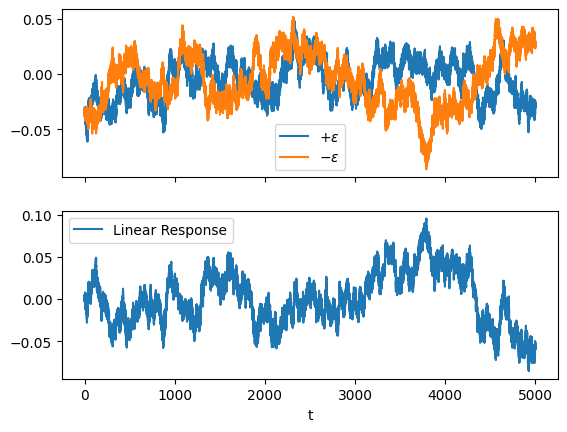

In [4]:
fig, ax = plt.subplots(nrows=2,sharex=True)
df_plus.plot(x="t",y="mean_x1",label=r"$+ \varepsilon$",ax=ax[0])
df_minus.plot(x="t",y="mean_x1",label=r"$- \varepsilon$",ax=ax[0])
df_response.plot(x="t",y="mean_x1",label="Linear Response",ax=ax[1])

In [ ]:
# fh = h5py.File(agg_path, 'r')
# fh.keys()
# dict(fh.attrs)
# fh.close()